In [16]:
import torch as t 
from torch.distributions import uniform
from typing import List, Callable
from ste_func import STEFunction
import numpy as np
from tqdm import tqdm
from reaction import rho
import matplotlib.pyplot as plt

In [2]:
def p1_(batch: t.Tensor, N: int, gamma: float, k1: float) -> t.Tensor:
    n = batch[:,0]
    # k1_bar = k1 / ((N - 1) * (N - 2))
    return gamma * (k1 / ((N-1)*(N-2))) * n * (n - 1) * (N - n)


def p2_(batch: t.Tensor, N: int, gamma: float, k1_star: float) -> t.Tensor:
    n = batch[:,0]
    # k1_star_bar = k1_star / ((N - 1) * (N - 2))
    return gamma * (k1_star / ((N-1) * (N-2))) * n * (N - n) * (N - 1 - n)


def p3_(cells: t.Tensor, N: int, gamma: float, k2: float) -> t.Tensor:
    n = cells[:,0]
    m = cells[:,1]
    # k2_bar = k2 / N
    return gamma * (k2 / N) * (N - n) * m


def p4_(cells: t.Tensor, N: int, gamma: float, k2_star: float) -> t.Tensor:
    n = cells[:,0]
    m = cells[:,1]
    # k2_star_bar = k2_star / N
    return gamma * (k2_star / N) * n * (N - m)


def p5_(cells: t.Tensor, N: int, gamma: float, k3: float) -> t.Tensor:
    n = cells[:,0]
    m = cells[:,1]
    # k3_bar = k3 / N
    return gamma * (k3 / N) * (N - n) * (N - m)


def p6_(cells: t.Tensor, N: int, gamma: float, k3_star: float) -> t.Tensor:
    n = cells[:,0]
    m = cells[:,1]
    # k3_star_bar = k3_star / N
    return gamma * (k3_star / N) * n * m

In [3]:
def rho_STE(
    batch: t.Tensor,
    N: int,
    gamma: t.Tensor,
    k1: t.Tensor,
    k1_bar: t.Tensor,
    k2: t.Tensor,
    k2_bar: t.Tensor,
    k3: t.Tensor,
    k3_bar: t.Tensor,
    num_reaction_channels: int,
):
    batch_size, grids_per_el, height, width = batch.shape
    # for each cell on the lattice, choose a reaction channel
    channels = t.randint(high=num_reaction_channels,
                         size=(batch_size, height, width))
    if batch.is_cuda:
        channels = channels.cuda()
    
    # handle reaction 1
    p_r1 = p1_(batch, N, gamma, k1)
    p_r1_expand = t.stack((p_r1, t.zeros(batch_size, height, width)), dim=1)
    chnl_msk = t.stack((channels == 0, t.zeros(batch_size, height, width)),dim=1)
    thresholds = uniform.Uniform(0, 1).sample((batch_size, 2, height, width))
    #batch += STEFunction.apply(p_r1_expand - thresholds) * chnl_msk
    p_r1_res = STEFunction.apply(p_r1_expand - thresholds) * chnl_msk

    # handle reaction 2
    p_r2 = p2_(batch, N, gamma, k1_bar)
    p_r2_expand = t.stack((p_r2, t.zeros(batch_size, height, width)), dim=1)
    chnl_msk = t.stack((channels == 1, t.zeros(batch_size, height, width)), dim=1)
    thresholds = uniform.Uniform(0, 1).sample((batch_size, 2, height, width))
    #batch -= STEFunction.apply(p_r2_expand - thresholds) * chnl_msk
    p_r2_res = STEFunction.apply(p_r2_expand - thresholds) * chnl_msk

    # handle reaction 3
    p_r3 = p3_(batch, N, gamma, k2)
    p_r3_expand = t.stack((p_r3, t.zeros(batch_size, height, width)), dim=1)
    chnl_msk = t.stack((channels == 2, t.zeros(batch_size, height, width)), dim=1)
    thresholds = uniform.Uniform(0, 1).sample((batch_size, 2, height, width))
    #batch += STEFunction.apply(p_r3_expand - thresholds) * chnl_msk
    p_r3_res = STEFunction.apply(p_r3_expand - thresholds) * chnl_msk

    # handle reaction 4
    p_r4 = p4_(batch, N, gamma, k2_bar)
    p_r4_expand = t.stack((p_r4, t.zeros(batch_size, height, width)), dim=1)
    chnl_msk = t.stack((channels == 3, t.zeros(batch_size, height, width)), dim=1)
    thresholds = uniform.Uniform(0, 1).sample((batch_size, 2, height, width))
    #batch -= STEFunction.apply(p_r4_expand - thresholds) * chnl_msk
    p_r4_res = STEFunction.apply(p_r4_expand - thresholds) * chnl_msk

    # handle reaction 5
    p_r5 = p5_(batch, N, gamma, k3)
    p_r5_expand = t.stack((t.zeros(batch_size, height, width), p_r5), dim=1)
    chnl_msk = t.stack((t.zeros(batch_size, height, width), channels == 4), dim=1)
    thresholds = uniform.Uniform(0, 1).sample((batch_size, 2, height, width))
    #batch += STEFunction.apply(p_r5_expand - thresholds) * chnl_msk
    p_r5_res = STEFunction.apply(p_r5_expand - thresholds) * chnl_msk

    # handle reaction 6
    p_r6 = p6_(batch, N, gamma, k3_bar)
    p_r6_expand = t.stack((t.zeros(batch_size, height, width), p_r6), dim=1)
    chnl_msk = t.stack((t.zeros(batch_size, height, width), channels == 5), dim=1)
    #batch -= STEFunction.apply(p_r6_expand - thresholds) * chnl_msk
    p_r6_res = STEFunction.apply(p_r6_expand - thresholds) * chnl_msk
            
    return batch + p_r1_res - p_r2_res + p_r3_res - p_r4_res + p_r5_res - p_r6_res


generate data

In [4]:
from reaction import p1, p2, p3, p4, p5, p6

In [5]:
def chop_and_shuffle_data(sequence, shuffle=True):
    """
    Chop the training data into a set of state transitions and shuffle the resulting set.

    sequences (np.ndarray): matrix of shape (n_sequences, steps_per_seq, grid_height, grid_width)
    """
    steps_per_seq, _, grid_height, grid_width = sequence.shape
    # each transition consists of 2 states
    indexer = np.arange(2)[None, :] + np.arange(steps_per_seq - 1)[:, None]
    chopped_set = np.zeros(
        [(steps_per_seq - 1), 2, 2, grid_height, grid_width]
    )
    chopped_set = sequence.detach().numpy()[indexer]
    if shuffle:
        np.random.shuffle(chopped_set)
    return t.tensor(chopped_set)

In [6]:
grid = t.zeros((2,15,15))
grid[:] = 50
grid[0,12:17] = 90
N = 100 
gamma = 0.005 
rate_coefficients = t.tensor([0.98,0.98,0.1,0.1,0.2,0.2])
probability_funcs = [p1,p2,p3,p4,p5,p6]
num_steps = 1_000
t.sum(grid[0])

tensor(13050.)

In [7]:
grid = grid.float()
sequence = t.zeros((num_steps, *grid.shape))

for i in tqdm(range(num_steps)):
    sequence[i] = grid.detach().clone()
    grid = rho(grid, N, gamma, rate_coefficients, probability_funcs, num_reaction_channels=6)

  0%|          | 0/1000 [00:00<?, ?it/s]/root/anaconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 1000/1000 [00:03<00:00, 295.94it/s]


In [8]:
dataset = chop_and_shuffle_data(sequence=sequence)

test gradient

In [9]:
def MSE(X, Y):
    return t.mean(t.sum((X-Y)**2, dim=((1,2,3))))

In [10]:
def dist(X, D1, D2):
    mse_D1 = MSE(X, D1)
    #print(mse_D1)
    mse_D2 = MSE(X, D2)
    #print(mse_D2)
    return (mse_D1 - mse_D2)**2

In [11]:
k1 = t.tensor(0.3)
k1_bar = t.tensor(0.98)
k2 = t.tensor(0.1)
k2_bar = t.tensor(0.1)
k3 = t.tensor(0.2)
k3_bar = t.tensor(0.2)
gamma = t.tensor(0.005)
X_ = dataset[:,0]
X = X_.clone().detach()
Y_obs = dataset[:,1]

k1.requires_grad_()
Y_sim = rho_STE(X, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar, num_reaction_channels=6)
dist_val = dist(X_, Y_obs, Y_sim)
t.autograd.set_detect_anomaly(True)
t.autograd.grad(dist_val, k1)


(tensor(-0.2445),)

In [12]:
t.autograd.set_detect_anomaly(False)

In [19]:
k1_vals = t.linspace(0.0001, 0.9999, 1000)

grads = []
for k1 in tqdm(k1_vals):
    k1.requires_grad_()
    Y_sim = rho_STE(X, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar, num_reaction_channels=6)
    dist_val = dist(X, Y_sim, Y_obs)
    gradient = t.autograd.grad(dist_val, k1)[0]
    grads.append(gradient.detach().clone().numpy())

100%|██████████| 1000/1000 [01:11<00:00, 13.91it/s]


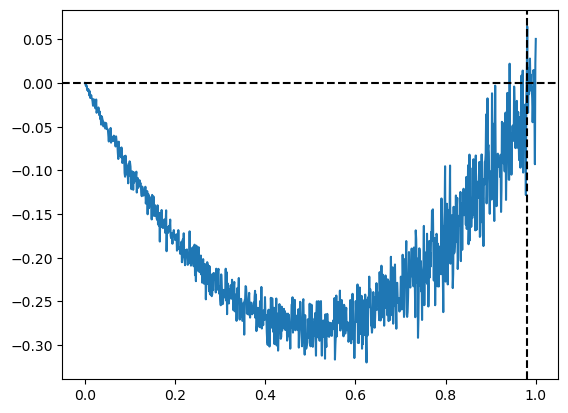

In [20]:
plt.plot(k1_vals, grads)
plt.axhline(0., color='black', linestyle="--")
plt.axvline(0.98, color='black', linestyle="--")